# PART I: Initialization

This cell must contain the location of the 'fsps' folder, which can be found inside the Dense Basis package (folder)

/.../fsps

In [2]:
%env SPS_HOME=

env: SPS_HOME=/home/aayushjoshi/DB/fsps/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import dense_basis as db
print('DB version: ',db.__version__)

import pandas
import lsst
from lsst.rsp import get_tap_service, retrieve_query

import numpy.polynomial.polynomial as poly
import scipy.signal
from scipy.signal import find_peaks

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
DB version:  0.1.9


## Variable Defination

Declare input parameters:
- `z_min`: Minimum redshift
- `z_max`: Maximum redshift
- `Nparams`: Number of lookback time parameters

**Important Note: These are the parameters that determine if the data is retrieved or processed before.**

In [4]:
# REDSHIFT RANGE
z_min = 0
z_max = 0.15

# NUMBER OF LOOKBACK PARAMETERS
Nparam = 3

## Enable TAP Service

In [5]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

## Visualize LSST Filters and transmission

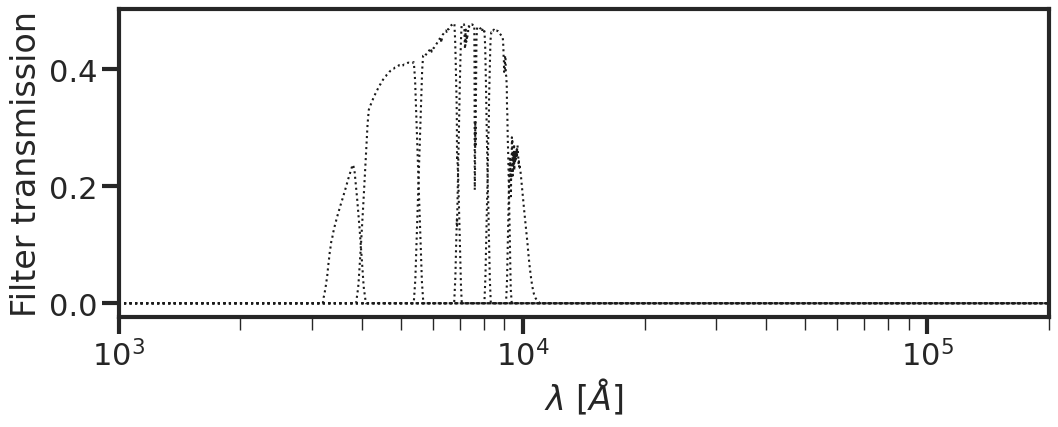

In [6]:
# filter set
filter_list = 'LSST_list.dat'
filt_dir = db.get_path(filter_list) # path to directory containing filter list
db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

## Create Prior Distribution

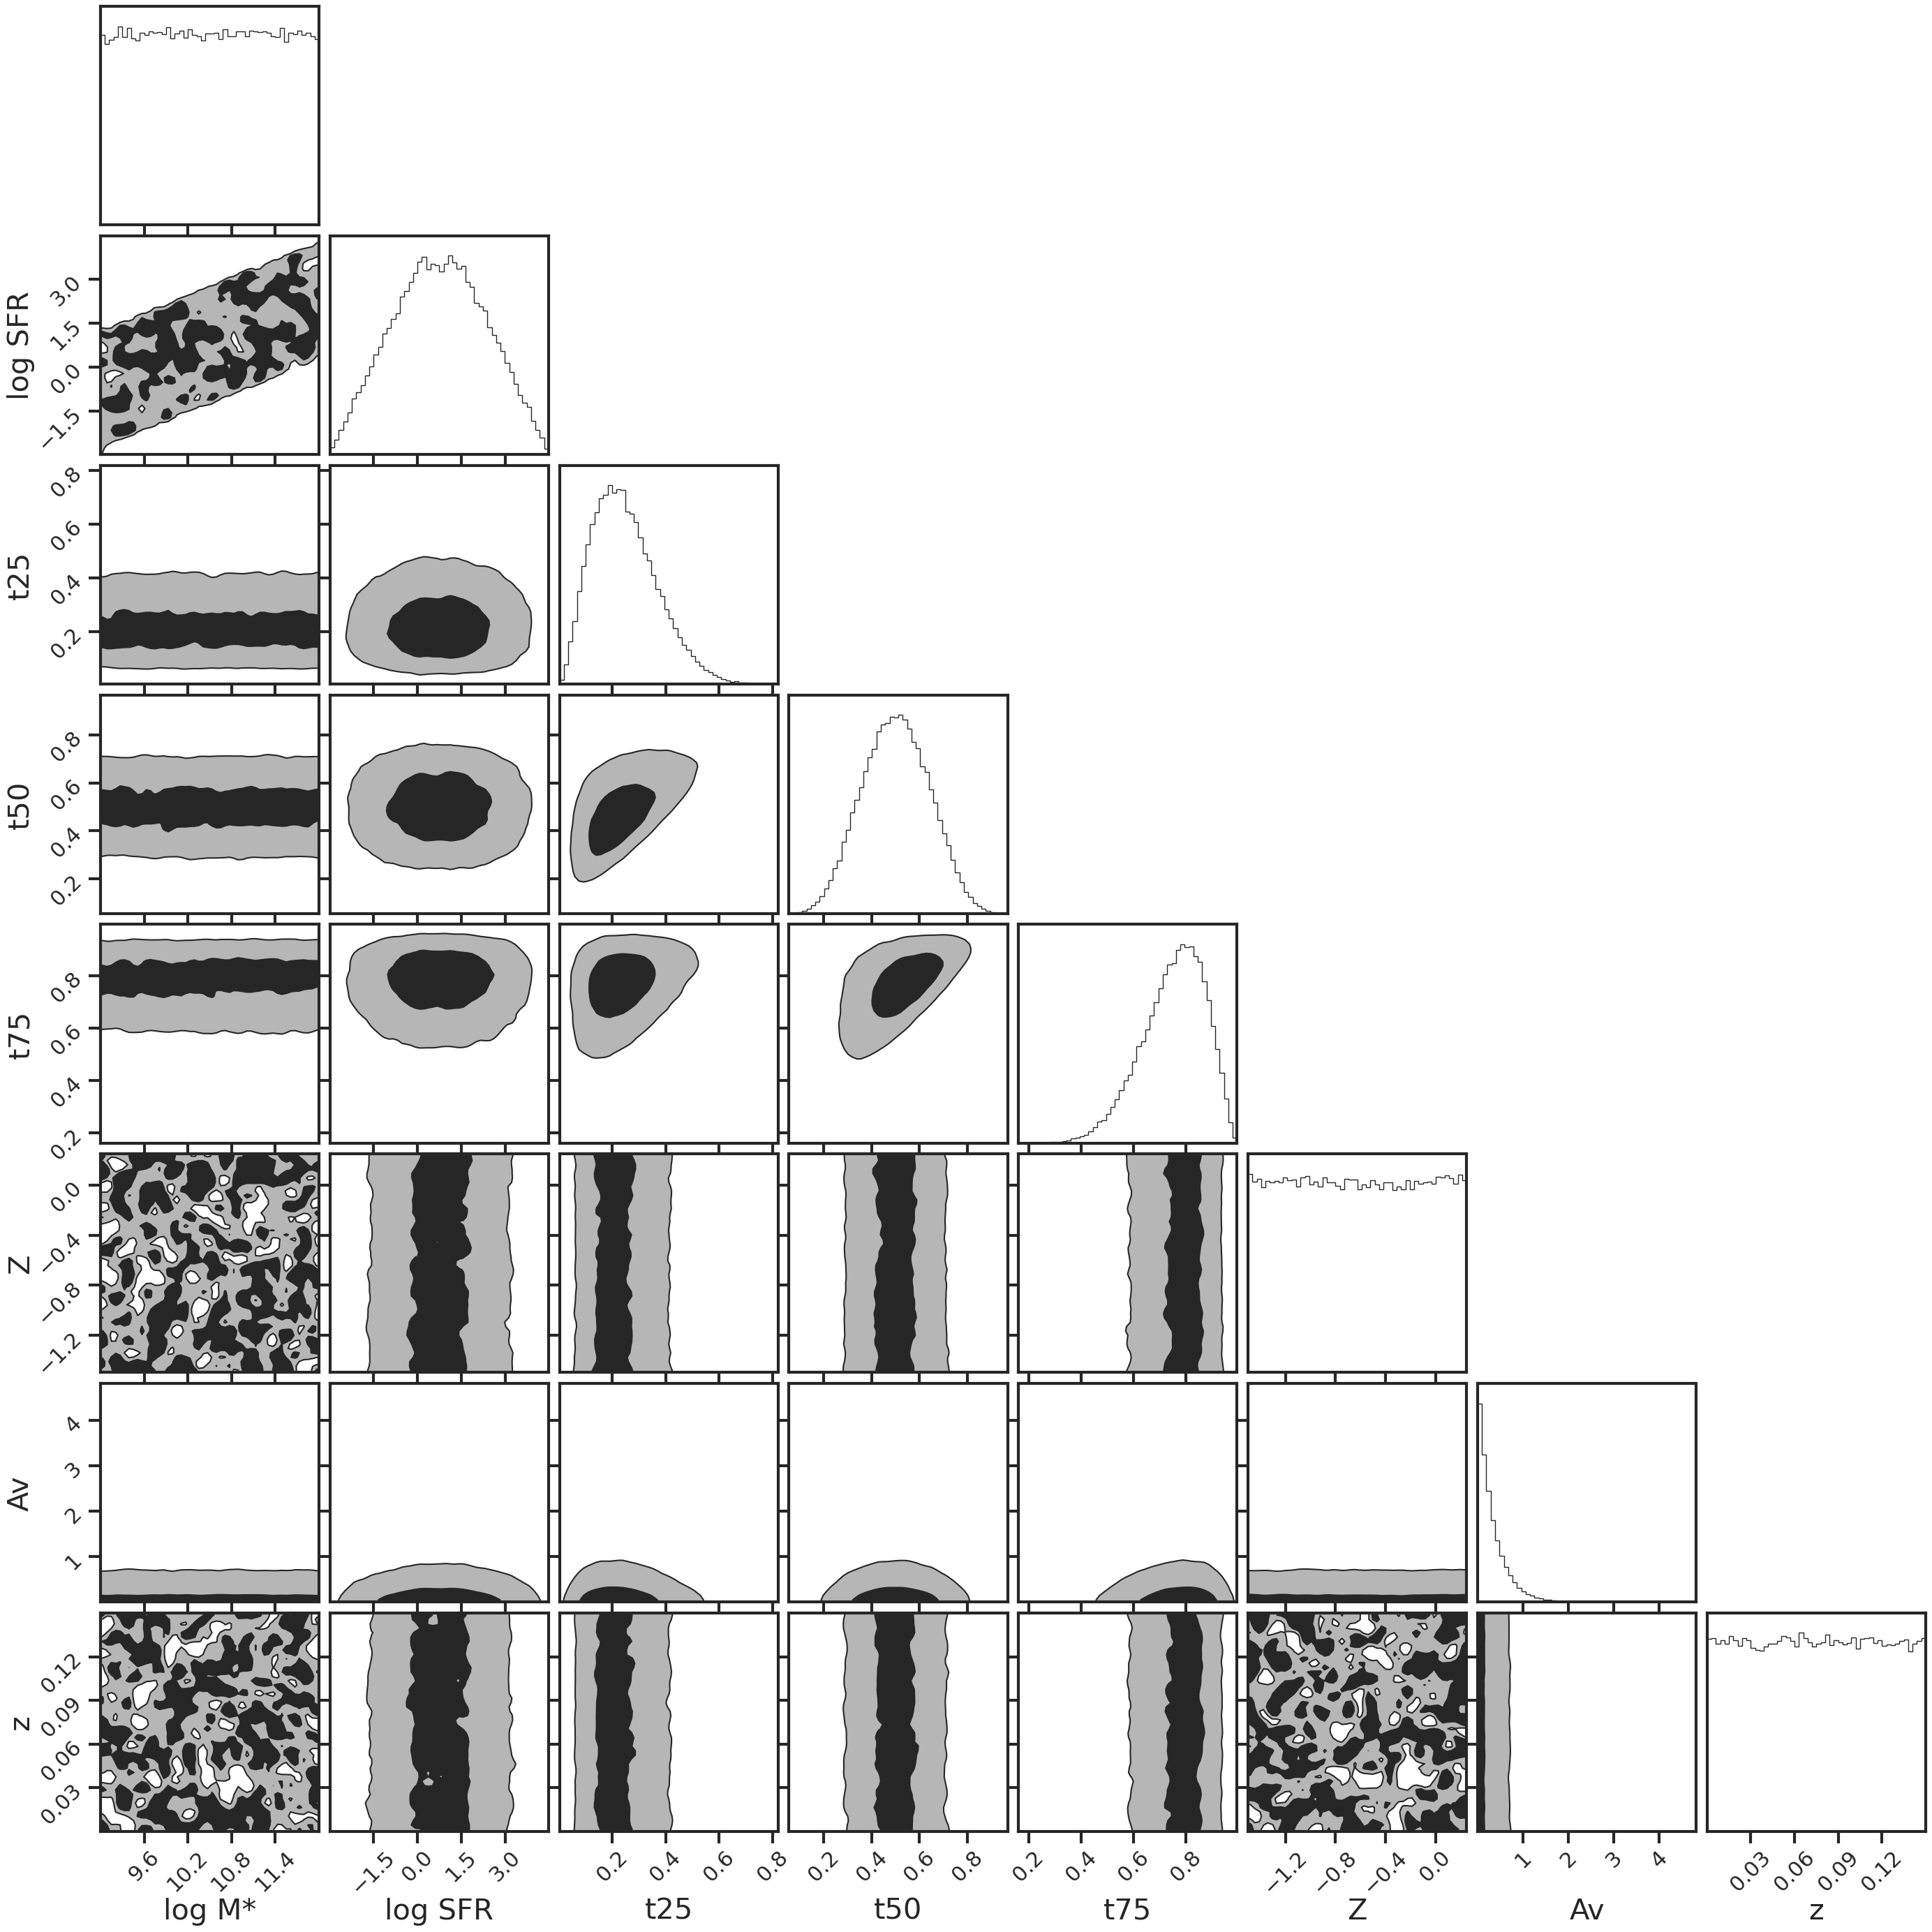

In [7]:
priors = db.Priors()

priors.tx_alpha = Nparam
priors.Nparam = Nparam

priors.z_min = z_min
priors.z_max = z_max

priors.plot_prior_distributions()

## Generate Atlas

This code first checks if atlas at that redshift range and Nparam exists. It will only generate the atlas if redshift range or Nparam were updated. 
> One must keep in mind to delete existing atlas to generate a new one if other dependent variable(s), like priors.tx_alpha, were changed.

In [8]:
# Atlas
N_pregrid = 10000
priors.Nparam = Nparam
path = 'pregrids/'

# CHECK IF PREGRIDS DIRECTORY EXIST
if not os.path.exists("pregrids"):
    os.makedirs("pregrids")
    print("New directory 'pregrids' created")
    
# FILENAME GENERATOR
ATLAS_fname = "atlas_z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split("."))
check_fname = ATLAS_fname + "_" + str(N_pregrid) + "_" + "Nparam" + "_" + str(Nparam) + ".dbatlas"

if os.path.exists(path + check_fname):
    print("The atlas with this name already exists.\nGenerate atlas skipped.")
else:
    db.generate_atlas(N_pregrid = N_pregrid, 
                priors = priors, 
                fname = ATLAS_fname, store=True, path='pregrids/',
                filter_list = filter_list, filt_dir = filt_dir)

# Load Atlas for later use
atlas = db.load_atlas(ATLAS_fname, N_pregrid = N_pregrid, N_param = priors.Nparam, path = path)


The atlas with this name already exists.
Generate atlas skipped.


## Data Retrieval from `DV_Dataframe`

Provide the number of galaxies that were processed during data retrieval to match the file name

In [9]:
num_of_galaxies = 5000

In [10]:
query_fname = "TAP-top" + str(num_of_galaxies) + "_z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + ".pkl"
ts_dv_fname = "DV_Dataframe/Truth/" + "z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + "_Nparam_" + str(Nparam)

# CHECK IF DATA HAS BEEN PROCESSED EARLIER
files = os.listdir(ts_dv_fname)
for file in files:
    if file[0:4] == "DV_0":
        print("Loading existing data for Truth : " + file)
        truth = pandas.read_pickle(ts_dv_fname + "/" + file)


obj_dv_fname = "DV_Dataframe/Object/" + "z_" + "".join(str(z_min).split(".")) + "_" + "".join(str(z_max).split(".")) + "_Nparam_" + str(Nparam)
# FOR OBJECT DATA
files = os.listdir(obj_dv_fname)
for file in files:
    if file[0:4] == "DV_0":
        print("Loading existing data for Object : " + file)
        obj = pandas.read_pickle(obj_dv_fname + "/" + file)


Loading existing data for Truth : DV_0_4999.pkl
Loading existing data for Object : DV_0_4999.pkl


If "Loading existing data from Truth/Object: xxx.pkl" does not appear, then data processing in `DB_Processor.ipynb` is pending for the given parameters

In [11]:
truth

,Mass,SFR,Z,t75,Burst,Dust
0,11.9915,0.6045,-0.2765,0.7245,2,0.9045
1,11.8565,0.5015,-0.2895,0.7235,2,0.6455
2,12.1115,0.7505,-0.2885,0.7245,2,0.6455
3,12.0715,0.7025,-0.2835,0.7245,2,0.6655
4,11.7695,0.3785,-0.2735,0.7245,2,0.9235
...,...,...,...,...,...,...
4995,9.9325,-0.8325,-0.9555,0.7945,2,0.1765
4996,10.2035,-0.6465,-0.6145,0.7685,2,0.2545
4997,10.4805,-0.5915,-0.7115,0.7685,2,0.2525
4998,10.0125,-0.6655,-0.9685,0.7975,2,0.1735


In [12]:
obj

,Mass,SFR,Z,t75,Burst,Dust
0,11.8765,0.4815,-0.2735,0.7265,2,0.8855
1,11.7585,0.3865,-0.2895,0.7255,2,0.6465
2,11.9865,0.6275,-0.2935,0.7255,2,0.6115
3,11.9585,0.5835,-0.2885,0.7265,2,0.6405
4,11.5745,0.1805,-0.2765,0.7265,2,0.8725
...,...,...,...,...,...,...
4995,9.5865,-1.3735,-0.9405,0.7915,2,0.1835
4996,10.1205,-0.9415,-0.6435,0.7685,2,0.2615
4997,10.6785,-0.4485,-0.6615,0.7615,2,0.2765
4998,10.1435,-0.6825,-0.9425,0.7955,2,0.1785


# PART II: Data Plots

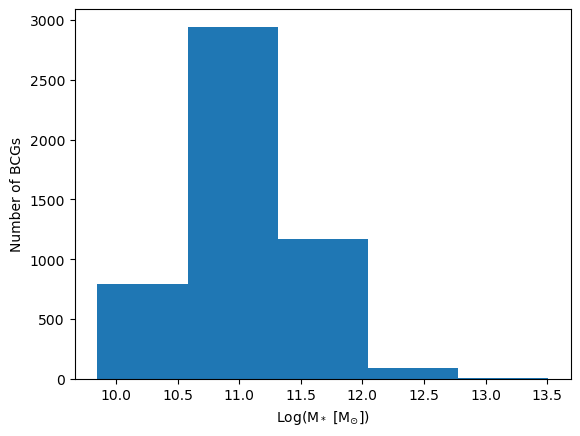

<Figure size 640x480 with 0 Axes>

In [6]:
fig=plt.figure()
plt.hist(truth['Mass'],bins=5)
plt.xlabel('Log(M$_*$ [M$_{\odot}$])')
plt.ylabel('Number of BCGs')
plt.show()
plt.savefig('histogram.png')

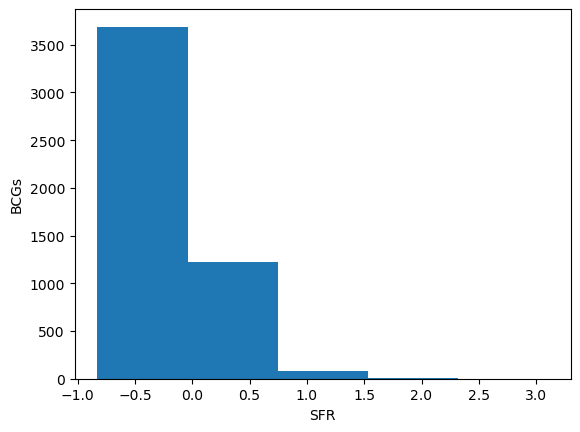

In [7]:
fig=plt.figure()
plt.hist(truth['SFR'],bins=5)
plt.xlabel('SFR')
plt.ylabel('BCGs')
plt.show()

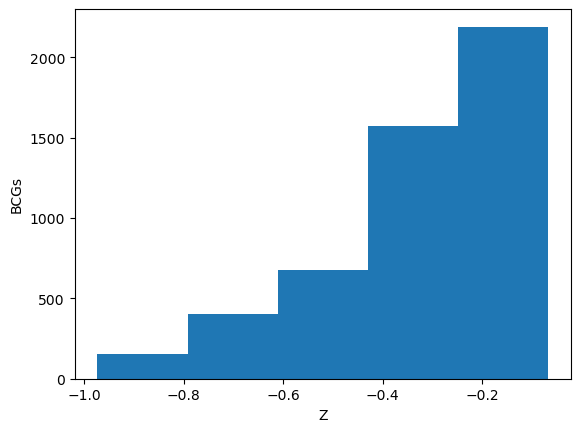

In [8]:
fig=plt.figure()
plt.hist(truth['Z'],bins=5)
plt.xlabel('Z')
plt.ylabel('BCGs')
plt.show()

Text(0, 0.5, 'SFR [M$_{\\odot}$/yr]')

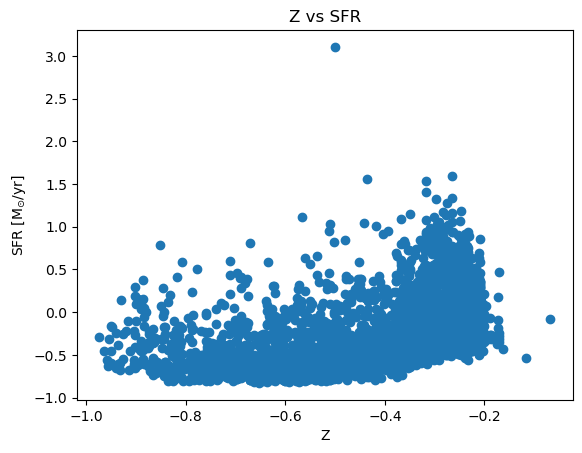

In [9]:
plt.scatter(truth['Z'],truth['SFR'])
plt.title('Z vs SFR')
plt.xlabel('Z')
plt.ylabel('SFR [M$_{\odot}$/yr]')

Text(0, 0.5, 'star formation rate')

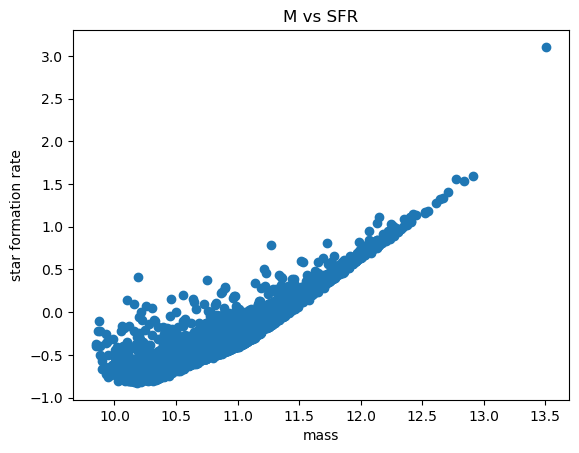

In [10]:
plt.scatter(truth['Mass'],truth['SFR'])
plt.title('M vs SFR')
plt.xlabel('mass')
plt.ylabel('star formation rate')

Text(0, 0.5, 'metallicity')

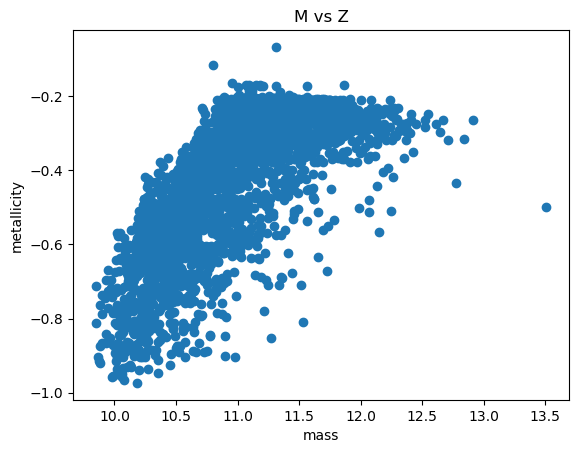

In [11]:
plt.scatter(truth['Mass'],truth['Z'])
plt.title('M vs Z')
plt.xlabel('mass')
plt.ylabel('metallicity')

In [12]:
thighmetal=truth[(truth['Z'] >= -0.4)]
thighmetal

,Mass,SFR,Z,Burst,Dust
0,12.0815,0.6925,-0.2115,2,0.6575
1,11.9205,0.5715,-0.2975,2,0.5295
2,12.1715,0.8195,-0.2915,2,0.5255
3,12.1265,0.7695,-0.2645,2,0.5365
4,11.8575,0.4585,-0.2095,2,0.6645
...,...,...,...,...,...
4955,11.4075,0.1395,-0.3605,2,0.4565
4960,10.8465,-0.3575,-0.3265,2,0.4475
4972,10.6765,-0.5125,-0.3625,2,0.4005
4974,10.4355,-0.7395,-0.3665,2,0.4025


In [13]:
tlowmetal=truth[(truth['Z'] <= -0.4)]
tlowmetal

,Mass,SFR,Z,Burst,Dust
44,12.7755,1.5555,-0.4355,2,0.3745
101,10.9125,-0.1185,-0.4995,2,0.3035
108,11.4525,0.3505,-0.5315,2,0.3005
109,10.7505,-0.2855,-0.4805,2,0.3115
112,11.1845,0.1255,-0.5695,2,0.2745
...,...,...,...,...,...
4995,9.9775,-0.6355,-0.9565,2,0.1735
4996,10.2335,-0.5225,-0.6195,2,0.2385
4997,10.4575,-0.5775,-0.7485,2,0.2255
4998,10.0355,-0.4565,-0.9495,2,0.1755


Text(0, 0.5, 'star formation rate')

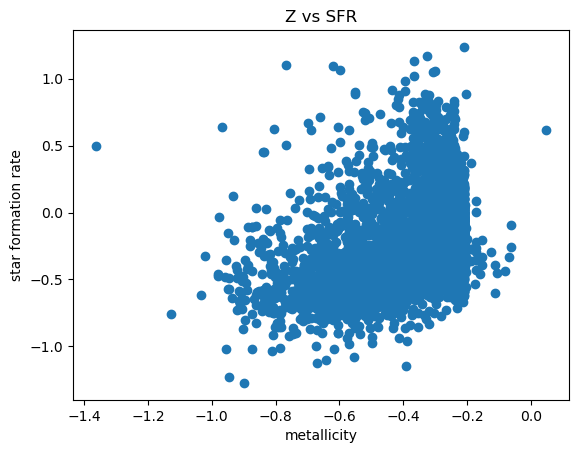

In [14]:
plt.scatter(obj['Z'],obj['SFR'])
plt.title('Z vs SFR')
plt.xlabel('metallicity')
plt.ylabel('star formation rate')

Text(0, 0.5, 'star formation rate')

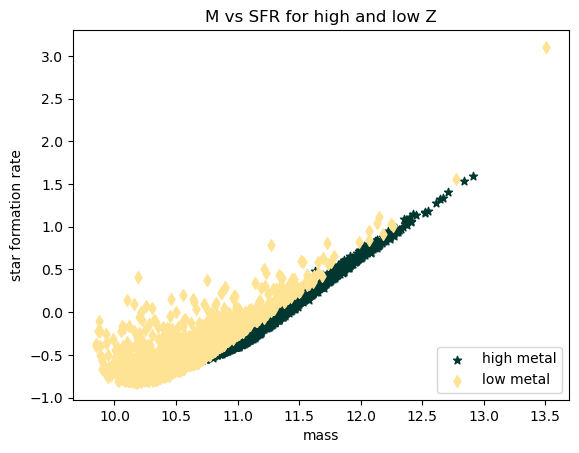

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
ax.scatter(thighmetal['Mass'],thighmetal['SFR'], color='#003831', marker="*", label='high metal')
ax.scatter(tlowmetal['Mass'], tlowmetal['SFR'], color='#FFE395', marker="d", label='low metal')
plt.legend(loc="lower right")
plt.title('M vs SFR for high and low Z')
plt.xlabel('mass')
plt.ylabel('star formation rate')

In [16]:
if Nparam == 3:
    fig=plt.figure()
    plt.hist(truth['t75'],bins=5)
    plt.title
    plt.xlabel('t75')
    plt.ylabel('number of bcgs')
    plt.show()
else:
    print("Nparam = 1; t75 dosen't exist")

Nparam = 1; t75 dosen't exist


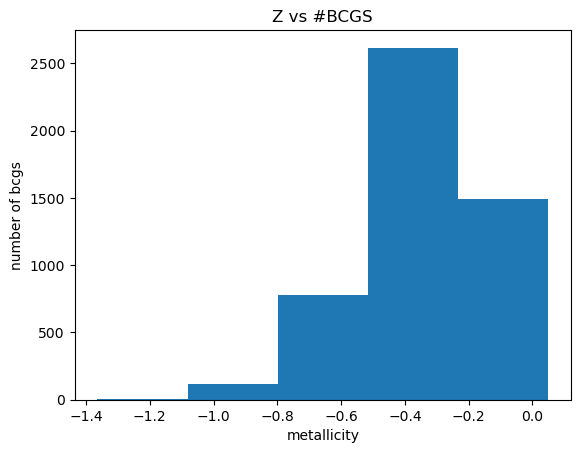

In [17]:
fig=plt.figure()
plt.hist(obj['Z'],bins=5)
plt.title('Z vs #BCGS')
plt.xlabel('metallicity')
plt.ylabel('number of bcgs')
plt.show()

In [18]:
obj

,Mass,SFR,Z,Burst,Dust
0,11.9635,0.5715,-0.2115,2,0.6365
1,11.7945,0.4365,-0.2755,2,0.5245
2,12.0395,0.6915,-0.3035,2,0.5135
3,12.0165,0.6485,-0.2765,2,0.5175
4,11.6635,0.2685,-0.2125,2,0.6205
...,...,...,...,...,...
4995,9.6085,-1.2285,-0.9475,2,0.1755
4996,10.1425,-0.8795,-0.6715,2,0.2365
4997,10.6565,-0.4245,-0.7095,2,0.2395
4998,10.1785,-0.4855,-0.9465,2,0.1755


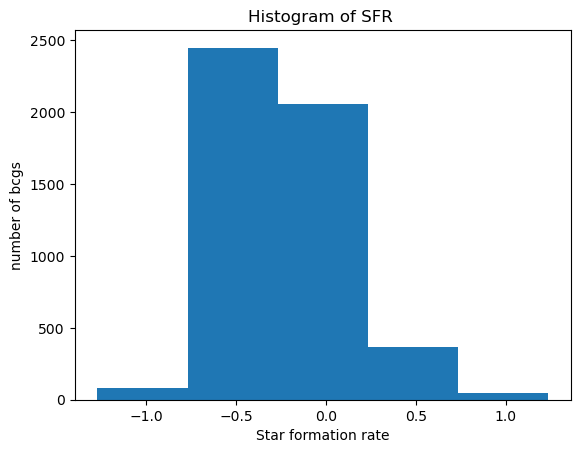

In [19]:
fig=plt.figure()
plt.hist(obj['SFR'],bins=5)
plt.title('Histogram of SFR ')
plt.xlabel('Star formation rate')
plt.ylabel('number of bcgs')
plt.show()

In [20]:
if Nparam == 3:
    fig=plt.figure()
    plt.hist(obj['t75'],bins=5)
    plt.title
    plt.xlabel('t75')
    plt.ylabel('number of bcgs')
    plt.show()
else:
    print("Nparam = 1; t75 dosen't exist")

Nparam = 1; t75 dosen't exist


Text(0, 0.5, 'metallicity')

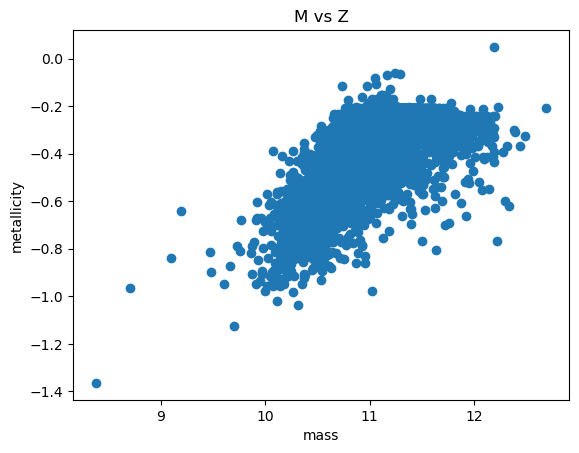

In [21]:
plt.scatter(obj['Mass'],obj['Z'])
plt.title('M vs Z')
plt.xlabel('mass')
plt.ylabel('metallicity')

Text(0, 0.5, 'star formation rate')

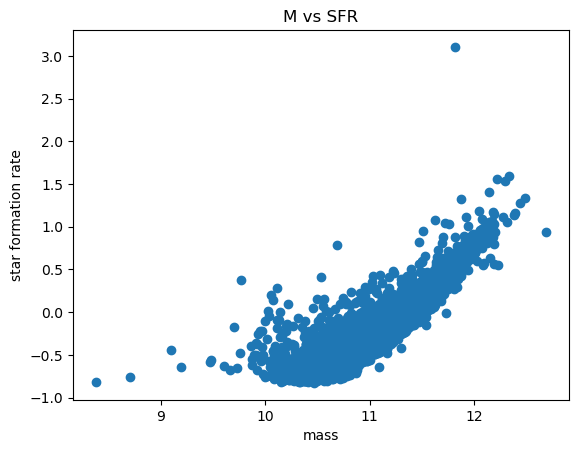

In [22]:
sSFR = truth['SFR']/truth['Mass']

plt.scatter(obj['Mass'],truth['SFR'])
plt.title('M vs SFR')
plt.xlabel('mass')
plt.ylabel('star formation rate')

Text(0, 0.5, 'star formation rate')

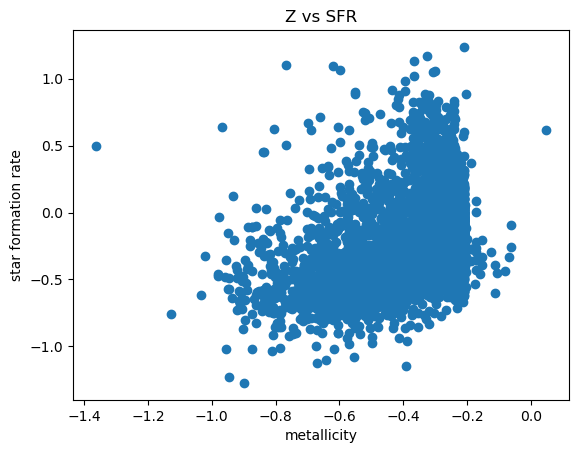

In [23]:
plt.scatter(obj['Z'],obj['SFR'])
plt.title('Z vs SFR')
plt.xlabel('metallicity')
plt.ylabel('star formation rate')

In [24]:
ohighmetal=obj[(obj['Z'] >= -0.6)]
ohighmetal

,Mass,SFR,Z,Burst,Dust
0,11.9635,0.5715,-0.2115,2,0.6365
1,11.7945,0.4365,-0.2755,2,0.5245
2,12.0395,0.6915,-0.3035,2,0.5135
3,12.0165,0.6485,-0.2765,2,0.5175
4,11.6635,0.2685,-0.2125,2,0.6205
...,...,...,...,...,...
4980,10.4355,-0.7585,-0.4505,2,0.3555
4984,11.2215,0.0295,-0.4965,2,0.3325
4986,10.6035,-0.6275,-0.5675,2,0.3335
4987,10.6635,-0.5105,-0.5935,2,0.3045


In [25]:
olowmetal=obj[(obj['Z'] <= -0.6)]
olowmetal

,Mass,SFR,Z,Burst,Dust
44,12.2215,1.0985,-0.7675,2,0.2035
108,11.0225,-0.0305,-0.9775,2,0.1485
161,11.8685,0.6375,-0.6055,2,0.2775
259,10.8465,-0.2875,-0.6555,2,0.2565
412,10.7695,-0.4215,-0.6155,2,0.2765
...,...,...,...,...,...
4995,9.6085,-1.2285,-0.9475,2,0.1755
4996,10.1425,-0.8795,-0.6715,2,0.2365
4997,10.6565,-0.4245,-0.7095,2,0.2395
4998,10.1785,-0.4855,-0.9465,2,0.1755


Text(0, 0.5, 'star formation rate')

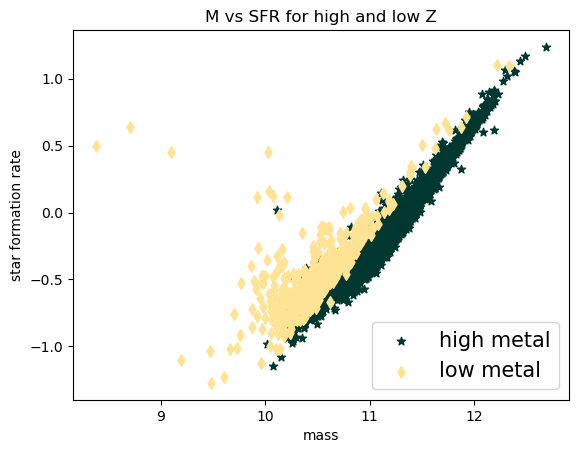

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
ax.scatter(ohighmetal['Mass'],ohighmetal['SFR'], color='#003831', marker="*", label='high metal')
ax.scatter(olowmetal['Mass'], olowmetal['SFR'], color='#FFE395', marker="d", label='low metal')
plt.legend(loc="lower right",fontsize=15)
plt.title('M vs SFR for high and low Z')
plt.xlabel('mass')
plt.ylabel('star formation rate')

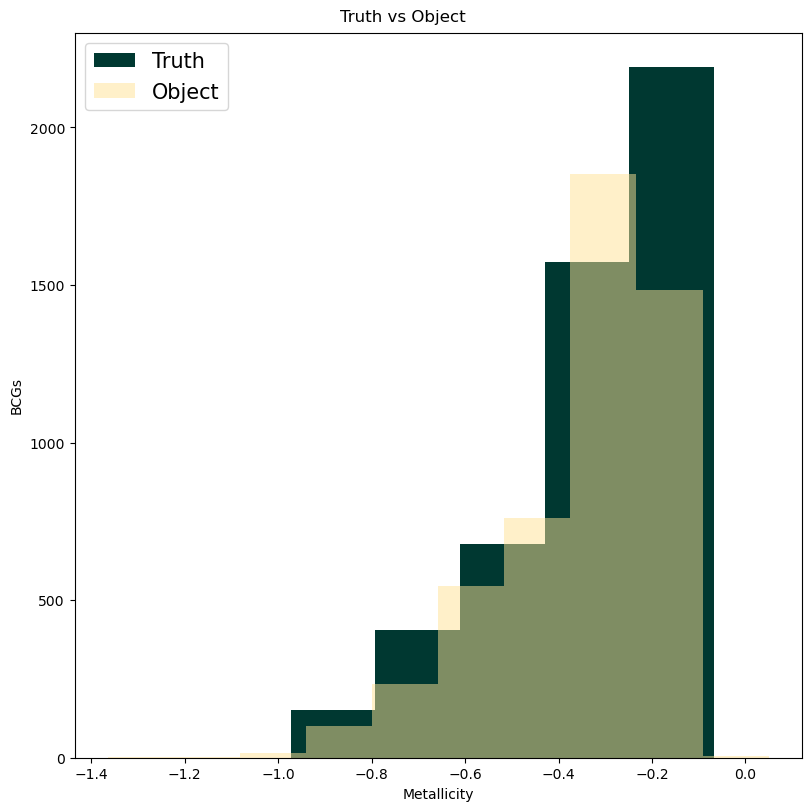

In [27]:
fig,(ax1) = plt.subplots(1,constrained_layout= True, figsize= (8,8))
fig.suptitle ('Truth vs Object ')
ax1.hist (truth['Z'],bins=5, color='#003831',label='Truth')
ax1.set_xlabel('Metallicity')
ax1.set_ylabel('BCGs')
ax1.hist (obj['Z'],bins=10, alpha = 0.5, color='#FFE395',label='Object')
plt.legend(loc="upper left",fontsize=15)
plt.show()

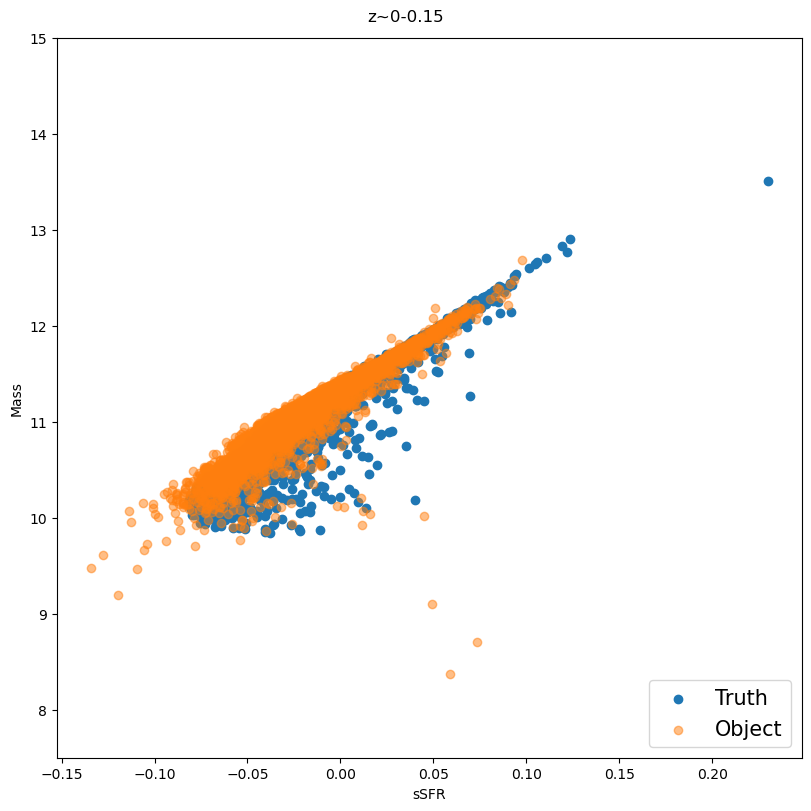

In [28]:
fig, (ax1) = plt.subplots(1,1,constrained_layout= True, figsize= (8,8))
fig.suptitle ('z~0-0.15')
ax1.scatter(truth['SFR']/truth['Mass'],truth['Mass'], label='Truth')
ax1.set_xlabel('sSFR')
ax1.set_ylabel('Mass')
ax1.scatter (obj['SFR']/obj['Mass'],obj['Mass'],alpha=0.5,label='Object')
plt.legend(loc="lower right",fontsize=15)
ax.legend(['Truth','Object'])
plt.legend(loc="lower right",fontsize=15)
ax1.set_ylim(7.5,15)
plt.show()

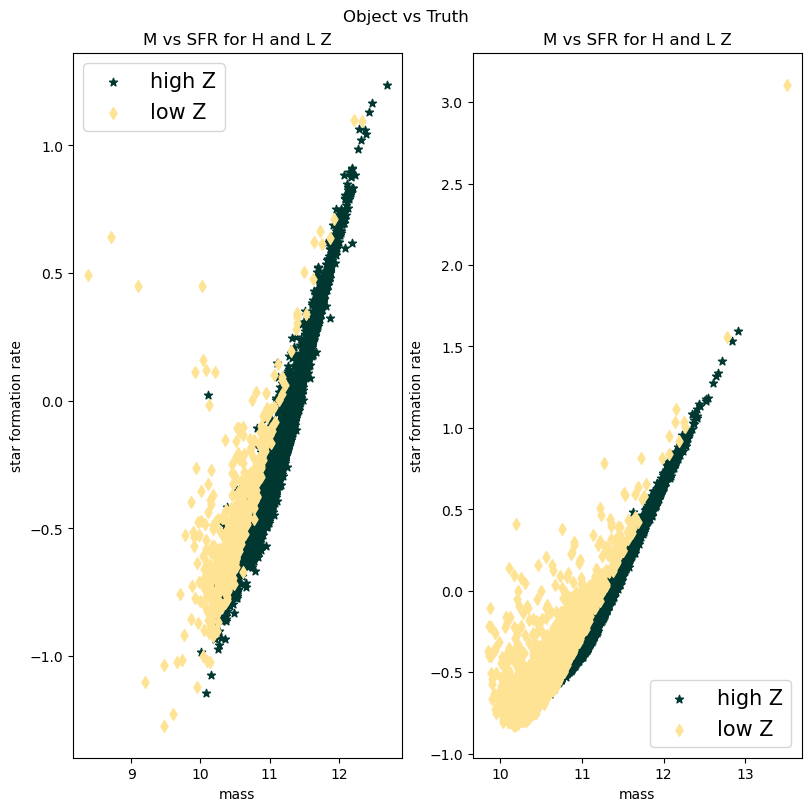

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,constrained_layout= True, figsize= (8,8))
fig.suptitle ('Object vs Truth')

 
ax1.scatter(ohighmetal['Mass'],ohighmetal['SFR'], color='#003831', marker="*", label='high metal')
ax1.scatter(olowmetal['Mass'], olowmetal['SFR'], color='#FFE395', marker="d", label='low metal')
ax1.legend(["high Z","low Z"],fontsize=15, loc="upper left")
ax1.set_title('M vs SFR for H and L Z')
ax1.set_xlabel('mass')
ax1.set_ylabel('star formation rate') 

 
ax2.scatter(thighmetal['Mass'],thighmetal['SFR'], color='#003831', marker="*", label='high metal')
ax2.scatter(tlowmetal['Mass'], tlowmetal['SFR'], color='#FFE395', marker="d", label='low metal')
ax2.legend(["high Z","low Z"],fontsize=15, loc="lower right")
ax2.set_title('M vs SFR for H and L Z')
ax2.set_xlabel('mass')
ax2.set_ylabel('star formation rate')
plt.show()

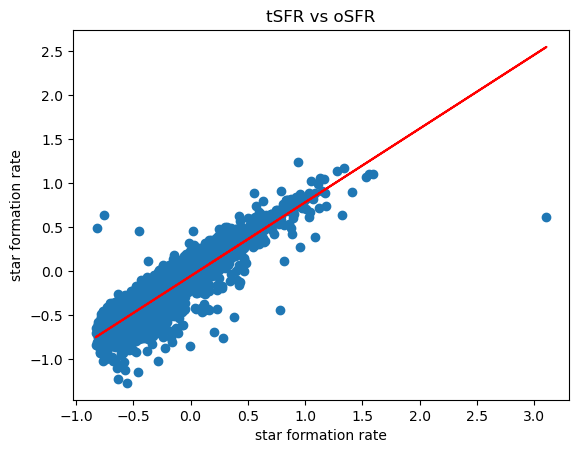

In [30]:
sSFR = truth['SFR']/obj['SFR']

plt.scatter(truth['SFR'],obj['SFR'])
plt.title('tSFR vs oSFR')
plt.xlabel('star formation rate')
plt.ylabel('star formation rate')
#calculate equation for trendline
z = np.polyfit(truth['SFR'].astype(float),obj['SFR'].astype(float), 1)
p = np.poly1d(z)
plt.plot(truth['SFR'], p(truth['SFR']),color='red')
plt.show()

In [31]:
p
# y=mx+b where m is 0.66 and b is 

poly1d([ 0.83875666, -0.05888827])

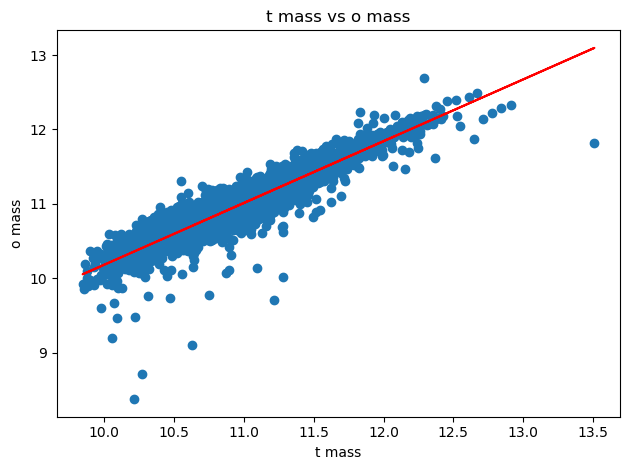

In [32]:
Mass =truth['Mass']/obj['Mass']

plt.scatter(truth['Mass'],obj['Mass'])
plt.title('t mass vs o mass')
plt.xlabel('t mass')
plt.ylabel('o mass')
#calculate equation for trendline
z = np.polyfit(truth['Mass'].astype(float),obj['Mass'].astype(float), 1)
p = np.poly1d(z)
plt.plot(truth['Mass'], p(truth['Mass']),color='red')
plt.tight_layout()
plt.show()

In [33]:
p

poly1d([0.83028662, 1.87923794])

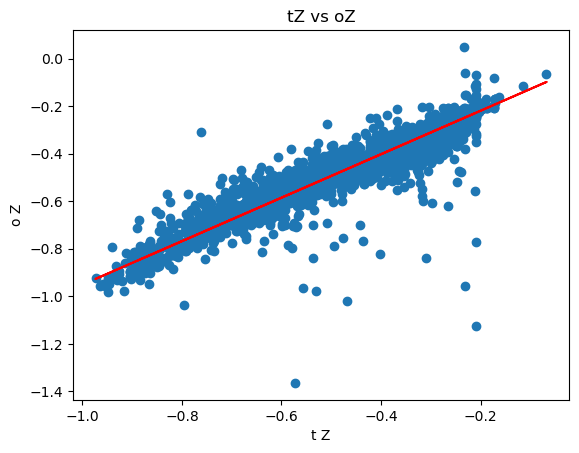

In [34]:
Z=truth['Z']/obj['Z']

plt.scatter(truth['Z'],obj['Z'])
plt.title('tZ vs oZ')
plt.xlabel('t Z')
plt.ylabel('o Z')
#calculate equation for trendline
z = np.polyfit(truth['Z'].astype(float),obj['Z'].astype(float), 1)
p = np.poly1d(z)
plt.plot(truth['Z'], p(truth['Z']),color='red')

In [35]:
p

poly1d([ 0.91474848, -0.03618584])

In [36]:
if Nparam == 3:
    t75=truth['t75']/obj['t75']

    plt.scatter(truth['t75'],obj['t75'])
    plt.title('t t75 vs o t75')
    plt.xlabel('t t75')
    plt.ylabel('o t75')
    #calculate equation for trendline
    z = np.polyfit(truth['t75'].astype(float),obj['t75'].astype(float), 1)
    p = np.poly1d(z)
    plt.plot(truth['t75'], p(truth['t75']),color='red')
    plt.show()
else:
    print("Nparam = 1; t75 does not exist")

Nparam = 1; t75 does not exist


In [37]:
p

poly1d([ 0.91474848, -0.03618584])

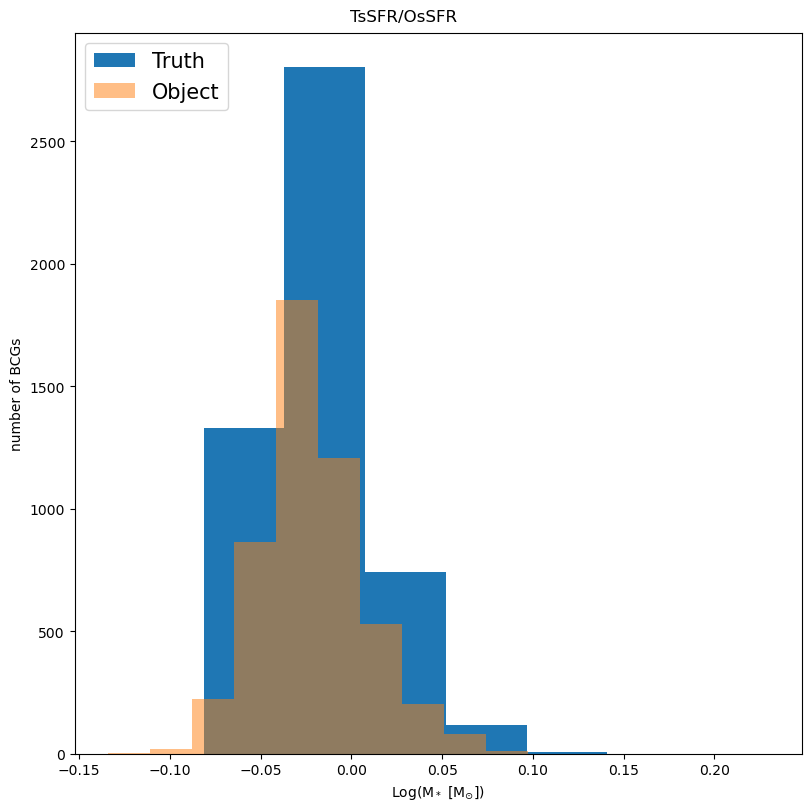

In [39]:
sSfr = obj['SFR']/obj['Mass']
fig,(ax1) = plt.subplots(1,constrained_layout= True, figsize= (8,8))
fig.suptitle ('TsSFR/OsSFR ')
ax1.set_xlabel('Log(M$_*$ [M$_{\odot}$])')
ax1.set_ylabel('number of BCGs')
ax1.hist (truth['SFR']/truth['Mass'],bins=7,label='Truth')
ax1.hist (obj['SFR']/obj['Mass'],alpha= 0.5,bins=10,label='Object')
plt.legend(loc="upper left",fontsize=15)
plt.show()

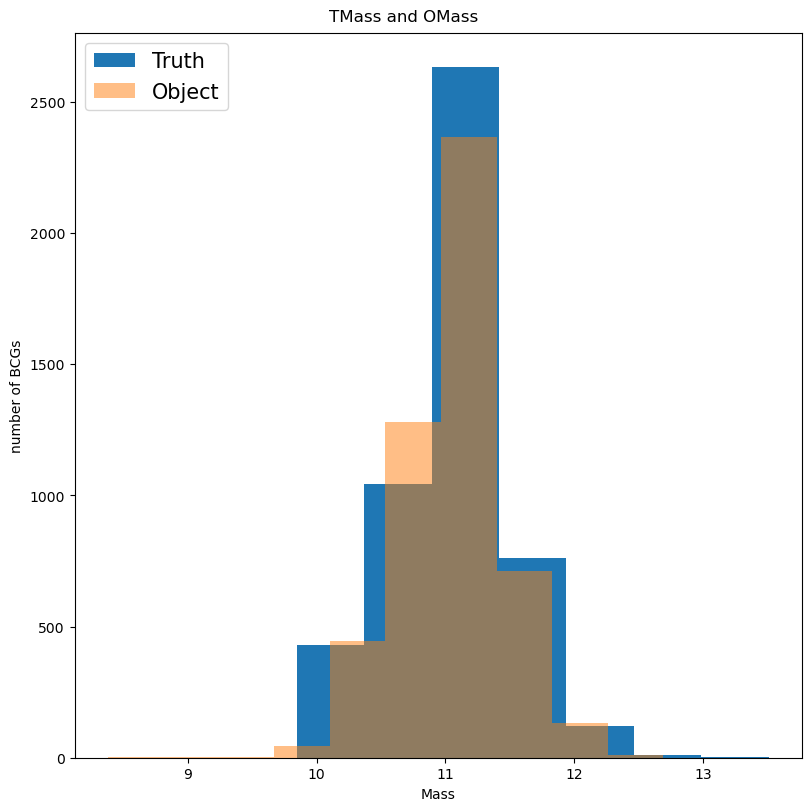

In [40]:
fig,(ax1) = plt.subplots(1,constrained_layout= True, figsize= (8,8))
fig.suptitle ('TMass and OMass ')
ax1.set_xlabel('Mass')
ax1.set_ylabel('number of BCGs')
ax1.hist (truth['Mass'],bins=7,label='Truth')
ax1.hist (obj['Mass'],alpha= 0.5,bins=10,label='Object')
plt.legend(loc="upper left",fontsize=15)
plt.show()

# PART III: Star Formation Histories

These cells are designed to pocess and study the star formation history of one galaxy at a time. From the given parameters, the processed data will be retrieved and sorted in the descreasing order of mass.

## Truth Catalog

In [13]:
# Load denseBCG
denseBCG = pandas.read_pickle("query/" + query_fname)

In [14]:
# Sorting
denseBCG=denseBCG.sort_values(by='Truth DB Mass', ascending=False)
denseBCG=denseBCG.reset_index()
denseBCG=denseBCG.drop(columns=['index'])
denseBCG

,ts_ra,ts_dec,ts_convmag_g,ts_convmag_r,obj_convmag_g,obj_convmag_r,ts_mag_r,ts_redshift,ts_flux_u,ts_flux_g,...,obj_u_cModelFluxErr,obj_g_cModelFluxErr,obj_r_cModelFluxErr,obj_i_cModelFluxErr,obj_z_cModelFluxErr,obj_y_cModelFluxErr,Distance (in pc),Absolute Magnitude,Truth DB Mass,Object DB Mass
0,60.554572,-35.974145,15.762368,14.740977,16.007377,15.034799,14.741000,0.104260,381280.000000,1799090.0,...,458.345928,263.824253,318.427956,537.607145,1035.811103,1338.488548,448108832.0,-23.515919,0,11.9635
1,69.103471,-33.760649,17.837992,16.895087,17.535960,16.626435,16.895100,0.072813,55110.601562,265952.0,...,182.315206,111.275764,136.932206,216.073032,460.704249,670.787885,312950656.0,-20.582283,0,11.2775
2,72.468896,-37.516368,17.416073,16.724470,17.701603,16.968809,16.724501,0.067271,119599.000000,392257.0,...,387.783594,179.611263,191.984365,347.168666,872.673610,1390.617805,289128608.0,-20.580957,0,10.8115
3,64.651544,-37.886710,17.708444,17.136793,17.447260,16.810242,17.136801,0.081338,103053.000000,299656.0,...,206.129470,117.715284,128.680013,185.812066,369.794403,527.271628,349590656.0,-20.580999,0,10.5785
4,70.591073,-35.438795,16.705994,15.854533,16.747027,15.930868,15.854500,0.045065,167677.000000,754402.0,...,288.877590,174.309105,180.195943,273.747476,472.621051,801.735109,193690816.0,-20.581047,0,11.4135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,52.040943,-37.434134,17.078624,16.285503,16.635706,15.837180,16.285500,0.075900,139885.000000,535242.0,...,396.217836,222.540354,234.985841,339.254375,745.619260,1049.136063,326217312.0,-21.282036,0,11.3535
4996,67.209380,-38.181348,18.206174,17.195999,18.345868,17.355881,17.195999,0.115486,39847.601562,189466.0,...,127.516129,74.326807,89.623847,141.038486,273.892896,433.872931,496358144.0,-21.282978,0,11.0975
4997,70.184446,-35.237494,16.335385,15.438056,16.407537,15.541015,15.438100,0.051399,226099.000000,1061320.0,...,367.203152,206.605727,227.984420,356.814165,627.256183,981.568156,220914736.0,-21.283024,0,11.6775
4998,61.848452,-36.106142,15.883777,15.166830,15.954907,15.242933,15.166800,0.045374,485761.000000,1608750.0,...,508.438259,281.365879,320.159573,499.797196,1059.166901,1479.070240,195016752.0,-21.283560,0,11.4615


log Stellar Mass: 10.21
Catalog Redshift: 0.0503781
sfh_tuple : 
[[10.4405 -0.8775  3.      0.2355  0.4895  0.7545]
 [ 9.6195 -1.8395  3.      0.1325  0.3285  0.6185]
 [10.8055  0.0295  3.      0.3845  0.6695  0.8595]]


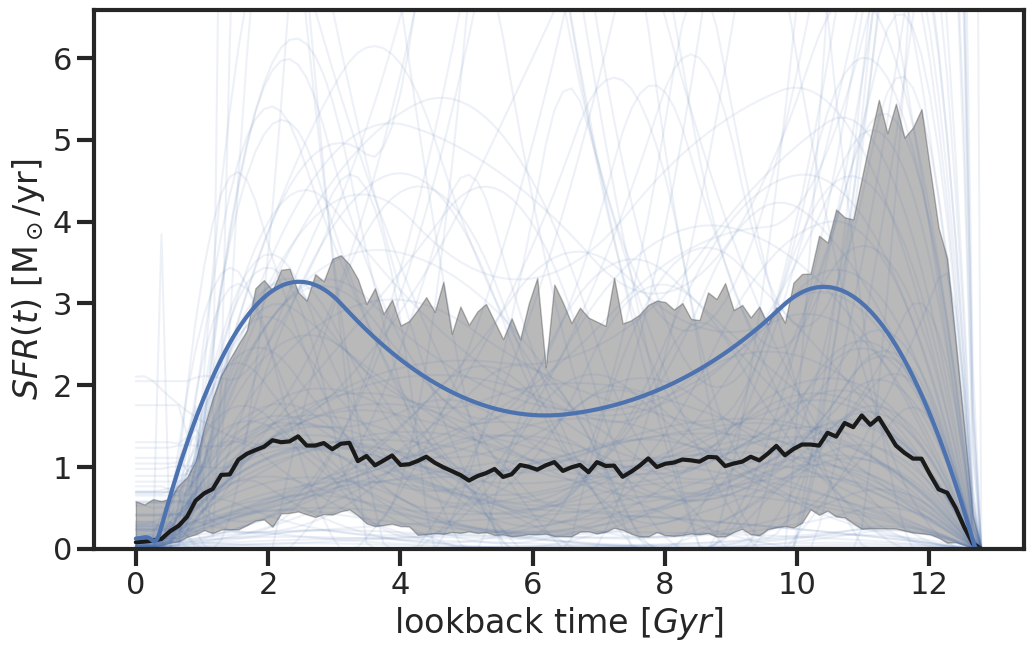

In [23]:
# SPECIFY THE GALAXY 
galaxy_num = 4999

for i in range(galaxy_num, galaxy_num + 1):
    
    filters = ['u','g','r','i','z','y']
    ts_obs_sed_list=[]
    ts_obs_err_list=[]
    for letter in filters:
        
        ts_flux = denseBCG[F"ts_flux_{letter}"][i] / 1000
        ts_flux_err=ts_flux * 0.1
    
        ts_obs_sed_list.append(ts_flux)
        ts_obs_err_list.append(ts_flux_err)
    
    ts_obs_sed=np.array(ts_obs_sed_list)
    ts_obs_err=np.array(ts_obs_err_list)
    
    # pass the atlas and the observed SED + uncertainties into the fitter, 
    ts_sedfit = db.SedFit(ts_obs_sed, ts_obs_err, atlas, fit_mask=[])

    # evaluate_likelihood returns the likelihood for each SED in the atlas and the norm value to
    # best match the observed SED with the atlas.
    ts_sedfit.evaluate_likelihood()

    # evaluate_posterior_percentiles calculates the 16,50,84th percentiles for 
    # the physical parameters - stellar mass, SFR, tx, dust, metallicity and redshift
    ts_sedfit.evaluate_posterior_percentiles()

    # Plots    
    print('log Stellar Mass: %.2f' %ts_sedfit.mstar[0])
    print('Catalog Redshift: ' + str(denseBCG['ts_redshift'][i]))
    print("sfh_tuple : ")
    print(ts_sedfit.sfh_tuple)
    
    # Grey plot
    ts_sedfit.plot_posterior_SFH(denseBCG['ts_redshift'][i])
    
    # Blue plot
    eval_SFH = db.tuple_to_sfh(ts_sedfit.sfh_tuple[0], denseBCG['ts_redshift'][i])
    ts_sfh_truths = [eval_SFH[1], eval_SFH[0]]
    
    plt.plot(np.amax(ts_sfh_truths[0]) - ts_sfh_truths[0], ts_sfh_truths[1], lw = 3)
    plt.show()


## Object Catalog

In [17]:
# Load denseBCG
denseBCG = pandas.read_pickle("query/" + query_fname)

In [18]:
# Sorting
denseBCG=denseBCG.sort_values(by='Object DB Mass', ascending=False)
denseBCG=denseBCG.reset_index()
denseBCG=denseBCG.drop(columns=['index'])
denseBCG

,ts_ra,ts_dec,ts_convmag_g,ts_convmag_r,obj_convmag_g,obj_convmag_r,ts_mag_r,ts_redshift,ts_flux_u,ts_flux_g,...,obj_u_cModelFluxErr,obj_g_cModelFluxErr,obj_r_cModelFluxErr,obj_i_cModelFluxErr,obj_z_cModelFluxErr,obj_y_cModelFluxErr,Distance (in pc),Absolute Magnitude,Truth DB Mass,Object DB Mass
0,67.521868,-36.515076,14.774485,13.912962,15.075445,14.154152,13.913000,0.044050,9.556020e+05,4468950.0,...,251.633685,419.005421,457.853711,584.009504,1071.287550,1651.658822,189327056.0,-22.473063,0,12.6905
1,50.933857,-38.957152,13.693474,12.863362,14.055815,13.234682,12.863400,0.017953,2.571710e+06,12095100.0,...,766.997739,658.928395,656.949919,1009.510597,1710.326765,2469.862294,77161456.0,-21.573605,0,12.4835
2,58.087577,-39.182952,13.831608,13.013506,14.111701,13.303487,13.013500,0.023980,2.235390e+06,10650200.0,...,819.028960,605.156504,708.978754,996.221885,1721.027333,2134.204598,103065464.0,-22.052067,0,12.4395
3,71.555813,-38.978241,14.194387,13.339125,14.408028,13.553066,13.339100,0.040907,1.621110e+06,7625090.0,...,748.217053,537.870690,572.056856,797.212793,1655.577315,1925.259022,175819760.0,-22.886238,0,12.3925
4,61.381864,-35.007105,14.193212,13.365285,14.339349,13.540729,13.365300,0.021732,1.641240e+06,7633350.0,...,664.477667,526.879507,601.919956,888.535669,1569.091457,1963.574371,93402288.0,-21.486492,0,12.3835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,55.916486,-37.899958,17.646920,17.165116,19.184857,18.675667,17.165100,0.027665,1.384100e+05,317126.0,...,300.494369,124.433755,123.000551,226.994757,551.942689,972.262103,118906152.0,-18.210922,0,9.4715
4996,68.028987,-37.629940,17.757715,17.285149,19.509809,19.210048,17.285101,0.080520,1.166470e+05,286361.0,...,262.582321,144.106709,109.443734,196.003929,573.904118,2136.502710,346073152.0,-20.410742,0,9.1955
4997,72.455294,-37.011496,17.269345,16.618249,18.048873,17.353657,16.618200,0.068239,1.490430e+05,449016.0,...,377.560222,151.136972,162.447600,285.162968,679.491813,519.961982,293290816.0,-20.718294,0,9.1025
4998,69.718049,-37.307325,17.964989,17.337214,18.142632,17.537076,17.337200,0.086811,8.303170e+04,236594.0,...,302.045427,117.844351,120.723160,219.504766,471.916362,559.257277,373115264.0,-20.522015,0,8.7105


log Stellar Mass: 8.41
Catalog Redshift: 0.0503781
sfh_tuple : 
[[ 8.4925  0.5255  3.      0.9925  0.9945  0.9965]
 [ 8.0175 -0.0095  3.      0.9815  0.9935  0.9965]
 [ 8.6445  0.6515  3.      0.9935  0.9955  0.9975]]


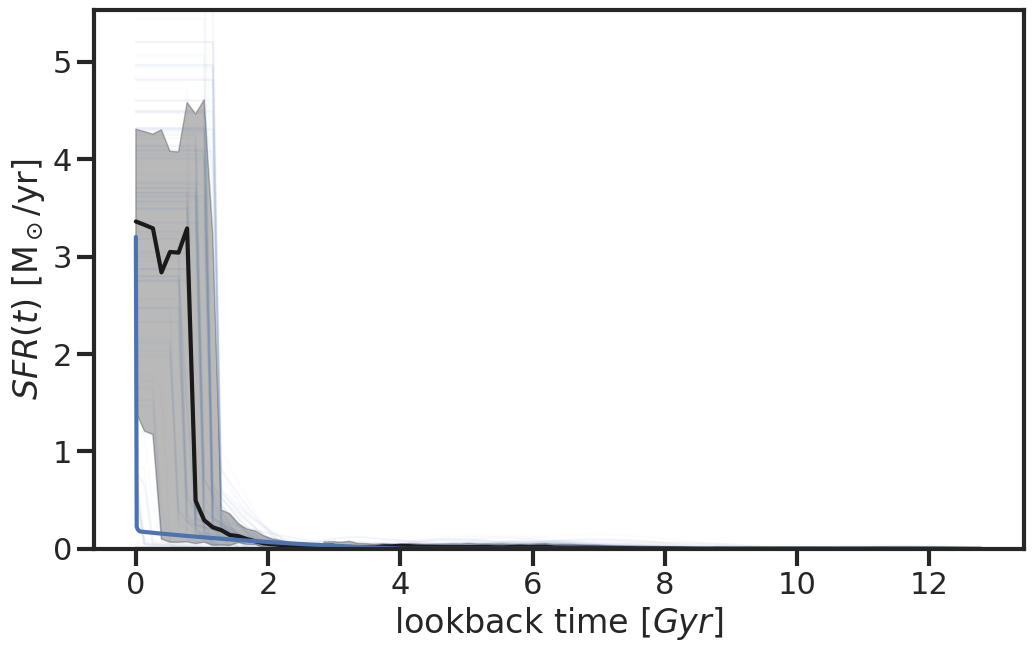

In [22]:
# SPECIFY THE GALAXY 
galaxy_num = 4999

for i in range(galaxy_num, galaxy_num + 1):
    
    filters=['u','g','r','i','z','y']
    obj_obs_sed_list=[]
    obj_obs_err_list=[]
    for letter in filters:
        obj_flux=denseBCG[F"obj_{letter}_cModelFlux"][i] / 1000
        obj_flux_err=obj_flux*0.1
   
        obj_obs_sed_list.append(obj_flux)
        obj_obs_err_list.append(obj_flux_err)
 
    obj_obs_sed=np.array(obj_obs_sed_list)
    obj_obs_err=np.array(obj_obs_err_list)
    
    # pass the atlas and the observed SED + uncertainties into the fitter, 
    obj_sedfit = db.SedFit(obj_obs_sed, obj_obs_err, atlas, fit_mask=[])

    # evaluate_likelihood returns the likelihood for each SED in the atlas and the norm value to
    # best match the observed SED with the atlas.
    obj_sedfit.evaluate_likelihood()

    # evaluate_posterior_percentiles calculates the 16,50,84th percentiles for 
    # the physical parameters - stellar mass, SFR, tx, dust, metallicity and redshift
    obj_sedfit.evaluate_posterior_percentiles()

    # Plots    
    print('log Stellar Mass: %.2f' %obj_sedfit.mstar[0])
    print('Catalog Redshift: ' + str(denseBCG['ts_redshift'][i]))
    print("sfh_tuple : ")
    print(obj_sedfit.sfh_tuple)
    
    # Grey plot
    obj_sedfit.plot_posterior_SFH(denseBCG['ts_redshift'][i])
    
    # Blue plot
    eval_SFH = db.tuple_to_sfh(obj_sedfit.sfh_tuple[0], denseBCG['ts_redshift'][i])
    obj_sfh_truths = [eval_SFH[1], eval_SFH[0]]
    
    plt.plot(np.amax(obj_sfh_truths[0]) - obj_sfh_truths[0], obj_sfh_truths[1], lw = 3)
    plt.show()
